In [1]:
from scipy import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
import itertools
import seaborn as sns
import shap

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler

In [5]:
creat = pd.read_csv('data/T_creatinine.csv')
dbp = pd.read_csv('data/T_DBP.csv')
demo = pd.read_csv('data/T_demo.csv')
glu = pd.read_csv('data/T_glucose.csv')
hgb = pd.read_csv('data/T_HGB.csv')
ldl = pd.read_csv('data/T_ldl.csv')
meds = pd.read_csv('data/T_meds.csv')
sbp = pd.read_csv('data/T_SBP.csv')
stage = pd.read_csv('data/T_stage.csv')

### A quick scrub through the data

In [6]:
test_list = [creat, dbp, glu, hgb, ldl, sbp]
for dd in test_list:
    print(dd.isnull().sum()['value']) # Will be non-zero if there is empty data

0
0
0
0
0
0


In [7]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
id        300 non-null int64
race      300 non-null object
gender    300 non-null object
age       300 non-null int64
dtypes: int64(2), object(2)
memory usage: 9.5+ KB


In [8]:
stage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
id                300 non-null int64
Stage_Progress    300 non-null bool
dtypes: bool(1), int64(1)
memory usage: 2.8 KB


In [9]:
stage['Stage_Progress'].mean()

0.3333333333333333

In short, the data is clean (there are no null or `nan` values), and each ID is a unique identifier of a single patient. However, there is a data imbalance imposed on this dataset which has to be appropriately addressed.

### Data exploration: macro level

Here I will briefly overview what the data at an overall level: the medications and blood values recorded across all patients.

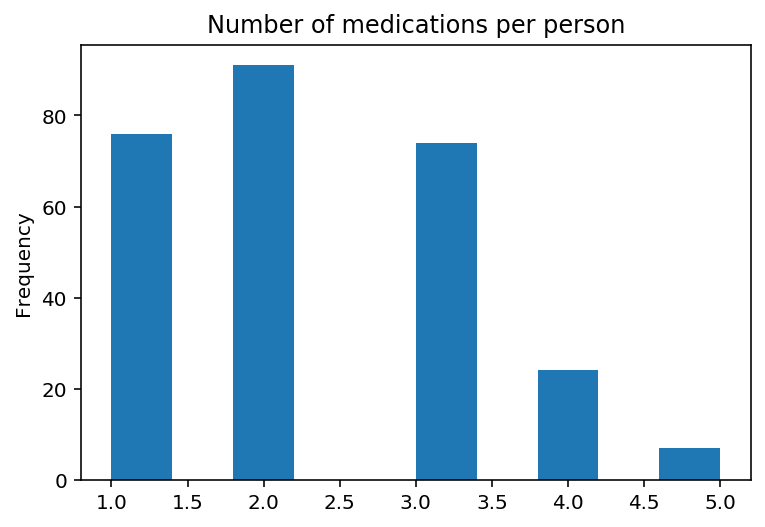

In [10]:
meds.groupby('id')['drug'].nunique().plot(kind='hist', title='Number of medications per person')

**Medications per person**. Every patient here is on at least one medication.

In [11]:
mdc = meds.copy()
mdc['drugcat'] = mdc['drug'].astype('category').cat.codes
num_people_on_list = zeros(21)
for i in range(300):
    select = unique(mdc[mdc['id']==i]['drugcat'])
    #print(select)
    for ss in select:
        num_people_on_list[ss] += 1
people_per_drug = pd.DataFrame( array([mdc['drug'].astype('category').cat.categories.values, num_people_on_list]).T, columns=['drug', 'people']).sort_values(by='people', ascending=False)        

Text(0, 0.5, 'Count')

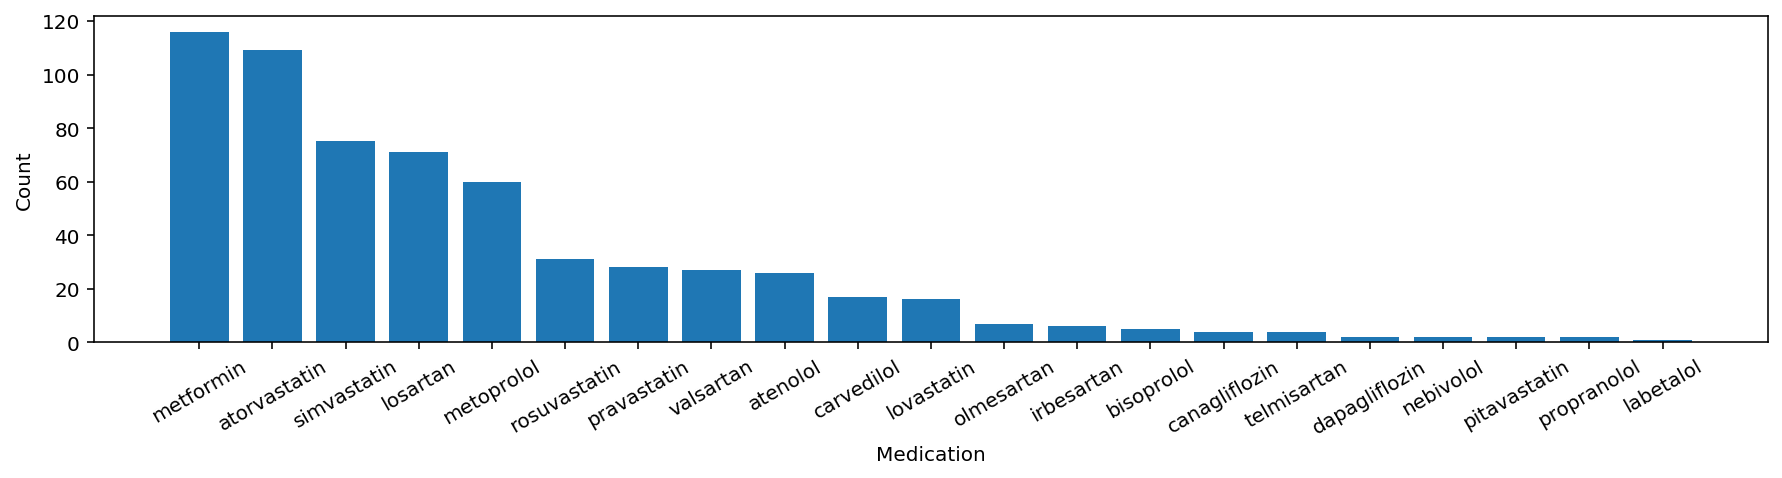

In [12]:
plt.figure(figsize=(15,3))
plt.bar(people_per_drug['drug'], people_per_drug['people'])
plt.xticks(rotation=30)
plt.xlabel('Medication')
plt.ylabel('Count')

**Most popular medications**. Of the 21 drugs that patients are taking, the most popular ones are first-line drugs for diabetes (e.g. metformin) or cholesterol.

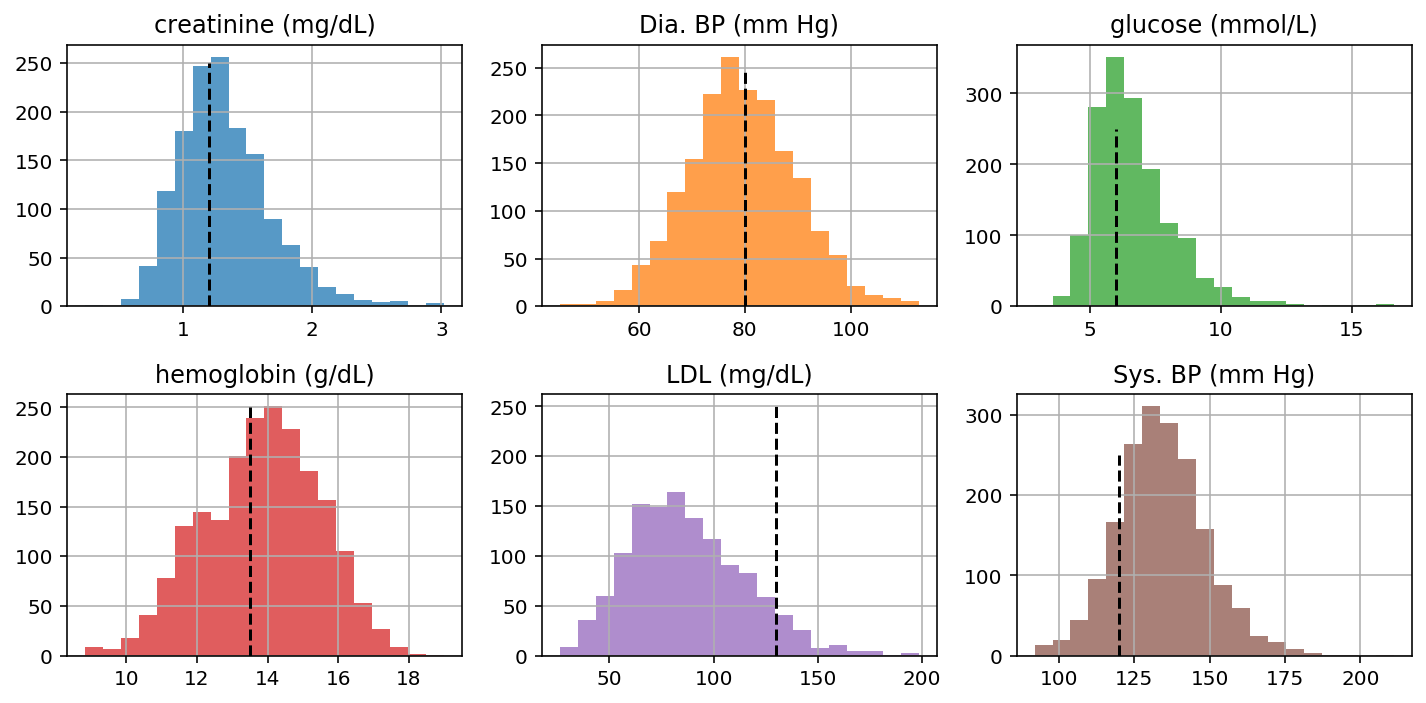

In [13]:
test_list = [creat, dbp, glu, hgb, ldl, sbp]
thresh_list = [1.2, 80, 6, 13.5, 130, 120]
label = ['creatinine (mg/dL)', 'Dia. BP (mm Hg)', 'glucose (mmol/L)', 'hemoglobin (g/dL)', 'LDL (mg/dL)', 'Sys. BP (mm Hg)']
cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

plt.figure(figsize=(10,5))
for i,tt in enumerate(test_list):
    plt.subplot(2,3,i+1)
    plt.plot([thresh_list[i], thresh_list[i]], [0, 250], 'k--')
    tt['value'].hist(bins=20, alpha=0.75, color = cols[i])
    plt.title(label[i])

plt.tight_layout()

**Blood test values for 6 metrics**. Healthy thresholds are marked in black dashed lines. Clearly, most of these people are not particularly healthy, and in fact skew well towards the unhealthy bound. 

I found something very curious, which is that although most people have healthy levels of LDL, but conversely unhealthy dia/sys BP, statins tend to be far more popular than blood pressure medications (angiotensin receptor blockers with the suffix `-tan`, or beta blockers with the suffix `-ol`). 

Beta blockers do not seem to be very popular compared to angiotensin receptor blockers. I found that beta blockers have severe side effects and are no longer recommended as first-line drugs for high blood pressure [1]. I also found that perhaps over the last decade or so medical research has suggested statins could be effective for high BP treatment, although the wisdom of such a practice has also been questioned [2].

[1] https://www.healio.com/cardiology/vascular-medicine/news/print/cardiology-today/%7B0e26cc5f-3bb6-4a0f-a389-dd6e77e5bc50%7D/beta-blockers-no-longer-recommended-for-first-line-treatment-of-uncomplicated-hypertension.

[2] https://www.health.harvard.edu/newsletter_article/Ask_the_doctor_Do_statins_affect_blood_pressure

**Insights**. These findings suggest that individual drugs should be incorporated into the final model, as a mismatch between the patient's condition and medication given could well be a useful indicator of CKD advancement. 

### Data exploration: patient level

Next I will look at the data set at a *patient* level: what conditions does a patient have? What treatments is he or she having? Do the treatments work at preventing CKD advancement?

In [14]:
def retrieve_patient(n, calcGFR=False):
    '''
    Retrieves the history of each patient.
    n: patient ID
    '''
    cols = [demo, dbp, creat, glu, hgb, ldl, meds, sbp, stage]
    labels = ['demo', 'dbp', 'creatinine', 'glucose', 'hgb', 'ldl', 'meds', 'sbp', 'stage']
    saved_data = {}
    for c,l in zip(cols,labels):
        saved_data[l] = c[c['id']==n].values[:,1:]
        
    k1 = 1; k2 = 1; alpha = -0.411; kappa = 0.9
    if calcGFR == True:
        if demo[demo['id']==n]['race'].values[0]=='Black':
            k2 = 1.159
        if demo[demo['id']==n]['gender'].values[0]=='Female':
            k1 = 1.018; alpha = -0.329; kappa = 0.7
        A = demo[demo['id']==n]['age'].values[0]
        factor1 = array([min(creat[creat['id']==n]['value'].values[i]/kappa,1) for i in range(len(creat[creat['id']==n]['value'].values))])
        factor2 = array([max(creat[creat['id']==n]['value'].values[i]/kappa,1) 
                         for i in range(len(creat[creat['id']==n]['value'].values))])
        saved_data['gfr'] = 141*factor1**(alpha) *(factor2)**(-1.209)*0.993**(A)*k1*k2
        saved_data['ckd'] = array(pd.cut(saved_data['gfr'], [0,15,30,45,60,90,200], labels=[5,4,3,2,1,0]).tolist())
        
    return saved_data

In [15]:
def patient_profile(n):
    
    '''
    Displays a time series of the patient's blood physiology and inferred CKD.
    '''
    
    pid = n
    pp = retrieve_patient(pid, calcGFR=True)
    
    sex = pp['demo'][0][1]
    
    print('Patient ID ' + str(pid), pp['demo'])
    print('CKD progressed ', pp['stage'][0])
    print('All drugs ',  unique(pp['meds'][:,0]) )
    
    statin_list = ['atorvastatin', 'rosuvastatin', 'pravastatin','simvastatin', 'lovastatin', 'pitavastatin']
    diab_list = ['metformin', 'canagliflozin', 'dapagliflozin']
    bp_list = ['valsartan', 'metoprolol', 'bisoprolol', 'atenolol', 'carvedilol',
               'olmesartan', 'irbesartan', 'telmisartan', 'labetalol', 'nebivolol', 'propranolol']
    
    
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(241)
    ax1.set_title('Diastolic BP')
    ax1.plot(pp['dbp'][:,1], pp['dbp'][:,0], 'o-', c='C0')
    ax1.plot(linspace(0,600,2), ones_like(linspace(0,600,2))*80, 'k--', lw=1)
    ax1.set_xlabel('Days')
    
    ax2 = plt.subplot(242)
    ax2.set_title('Systolic BP')
    ax2.plot(pp['sbp'][:,1], pp['sbp'][:,0], 'o-', c='C0')
    ax2.plot(linspace(0,600,2), ones_like(linspace(0,600,2))*120, 'k--', lw=1)
    ax2.set_xlabel('Days')
    ax2.set_ylim([50,170])

    ax3=plt.subplot(243)
    ax3.set_title('Glucose')
    ax3.plot(pp['glucose'][:,1], pp['glucose'][:,0], 's-', c='C1')
    ax3.plot(linspace(0,600,2), ones_like(linspace(0,600,2))*6, 'k--', lw=1)
    ax3.set_ylim([0,15])
    ax3.set_xlabel('Days')

    ax4 = plt.subplot(244)
    ax4.set_title('LDL')
    ax4.plot(pp['ldl'][:,1], pp['ldl'][:,0], 'd-', c='C2')
    ax4.plot(linspace(0,600,2), ones_like(linspace(0,600,2))*130, 'k--', lw=1)
    #plt.ylim([0,15])
    ax4.set_xlabel('Days')

    ax5 = plt.subplot(245)
    ax5.set_title('Creatinine')
    ax5.plot(pp['creatinine'][:,1], pp['creatinine'][:,0], '8-', c='C4')
    ax5.plot(linspace(0,600,2), ones_like(linspace(0,600,2))*1.2, 'k--', lw=1)
    #plt.ylim([0,15])
    ax5.set_xlabel('Days')

    ax6 = plt.subplot(246)
    ax6.plot(pp['hgb'][:,1], pp['hgb'][:,0], 'D-', c='C5')
    if sex=='Male':
        ax6.plot(linspace(0,1000,2), ones_like(linspace(0,600,2))*17.5, 'k--', lw=1)
        ax6.plot(linspace(0,1000,2), ones_like(linspace(0,600,2))*13.5, 'k--', lw=1)
    else:
        ax6.plot(linspace(0,1000,2), ones_like(linspace(0,600,2))*12, 'k--', lw=1)        
        ax6.plot(linspace(0,1000,2), ones_like(linspace(0,600,2))*15.5, 'k--', lw=1)

    ax6.set_title('Hemoglobin')
    ax6.set_xlabel('Day')


    ax7 = plt.subplot(247)
    ax7.plot(pp['creatinine'][:,1], pp['gfr'], 'ko-')
    ax7.set_title('Inferred GFR')
    ax7.set_xlabel('Day')
    ax7.set_ylim([0,100])
    #plt.ylim([0,5])

    ax8 = plt.subplot(248)
    ax8.plot(pp['creatinine'][:,1], pp['ckd'], 'ks-')
    ax8.set_title('Inferred CKD stage')
    ax8.set_xlabel('Day')
    ax8.set_ylim([0,5])

        
    for pm in pp['meds']:
        if pm[0] in statin_list:
            ax4a = ax4.twinx()
            ax4a.plot(pm[2:], [pm[1], pm[1]],  '-', c='C3', lw=2)
            ax4a.set_ylabel('Dose', color='C3')
            ax4a.tick_params(axis='y', labelcolor='C3')    

        if pm[0] in diab_list:
            ax3a = ax3.twinx()
            ax3a.plot(pm[2:], [pm[1], pm[1]],  '-', c='C3', lw=2)
            ax3a.set_ylabel('Dose', color='C3')
            ax3a.tick_params(axis='y', labelcolor='C3')    
            
        if pm[0] in bp_list:
            ax1a = ax1.twinx()
            ax1a.plot(pm[2:], [pm[1], pm[1]],  '-', c='C3', lw=2)
            ax1a.set_ylabel('Dose', color='C3')
            ax1a.tick_params(axis='y', labelcolor='C3')    
            
            ax2a = ax2.twinx()
            ax2a.plot(pm[2:], [pm[1], pm[1]],  '-', c='C3', lw=2)
            ax2a.set_ylabel('Dose', color='C3')
            ax2a.tick_params(axis='y', labelcolor='C3')    
            

    plt.tight_layout()

In [16]:
def treatment_count(n):
    pid = n
    pp = retrieve_patient(pid, calcGFR=False)

    bp_list = ['valsartan', 'metoprolol', 'bisoprolol', 'atenolol', 'carvedilol',
               'olmesartan', 'irbesartan', 'telmisartan', 'labetalol', 'nebivolol', 'propranolol']
    diab_list = ['metformin', 'canagliflozin', 'dapagliflozin']
    statin_list = ['atorvastatin', 'rosuvastatin', 'pravastatin','simvastatin', 'lovastatin', 'pitavastatin']

    med_list = unique(pp['meds'][:,0])
    med_end = pp['meds'][:,3]

    has_chol = 0
    has_diab = 0
    has_hbp = 0
    if True in (pp['ldl'][:,0] > 130):
        has_chol = 1
    if True in (pp['glucose'][:,0] > 6):
        has_diab = 1
    if True in (pp['sbp'][:,0] > 130):
        has_hbp = 1    
    if True in (pp['dbp'][:,0] > 80):                
        has_hbp = 1    
    
    num_diseases = has_chol + has_diab + has_hbp
    
    treat_bp = 0
    treat_diab = 0
    treat_chol = 0
    thres_dbp = 80; thres_sbp = 120; thres_glu = 6; thres_ldl = 130

    for md in med_list:
        if md in bp_list:
            treat_bp = 1
        if md in diab_list:
            treat_diab = 1
        if md in statin_list:
            treat_chol = 1

    treat_succ_count = 0
    treat_fail_count = 0
    if treat_diab == 1:
        if pp['glucose'][:,0][-1] < thres_glu:
            treat_succ_count += 1
        else:
            treat_fail_count += 1

    if treat_bp == 1:
        if (pp['sbp'][:,0][-1] < thres_sbp) or (pp['dbp'][:,0][-1] < thres_dbp):
            treat_succ_count += 1
        else:
            treat_fail_count += 1

    if treat_chol == 1:
        if (pp['ldl'][:,0][-1] < thres_ldl):
            treat_succ_count += 1
        else:
            treat_fail_count += 1
            
    return treat_succ_count, treat_fail_count, num_diseases 

### Patient profiles

Patient ID 0 [['Unknown' 'Male' 70]]
CKD progressed  [True]
All drugs  ['atorvastatin' 'losartan' 'metformin']


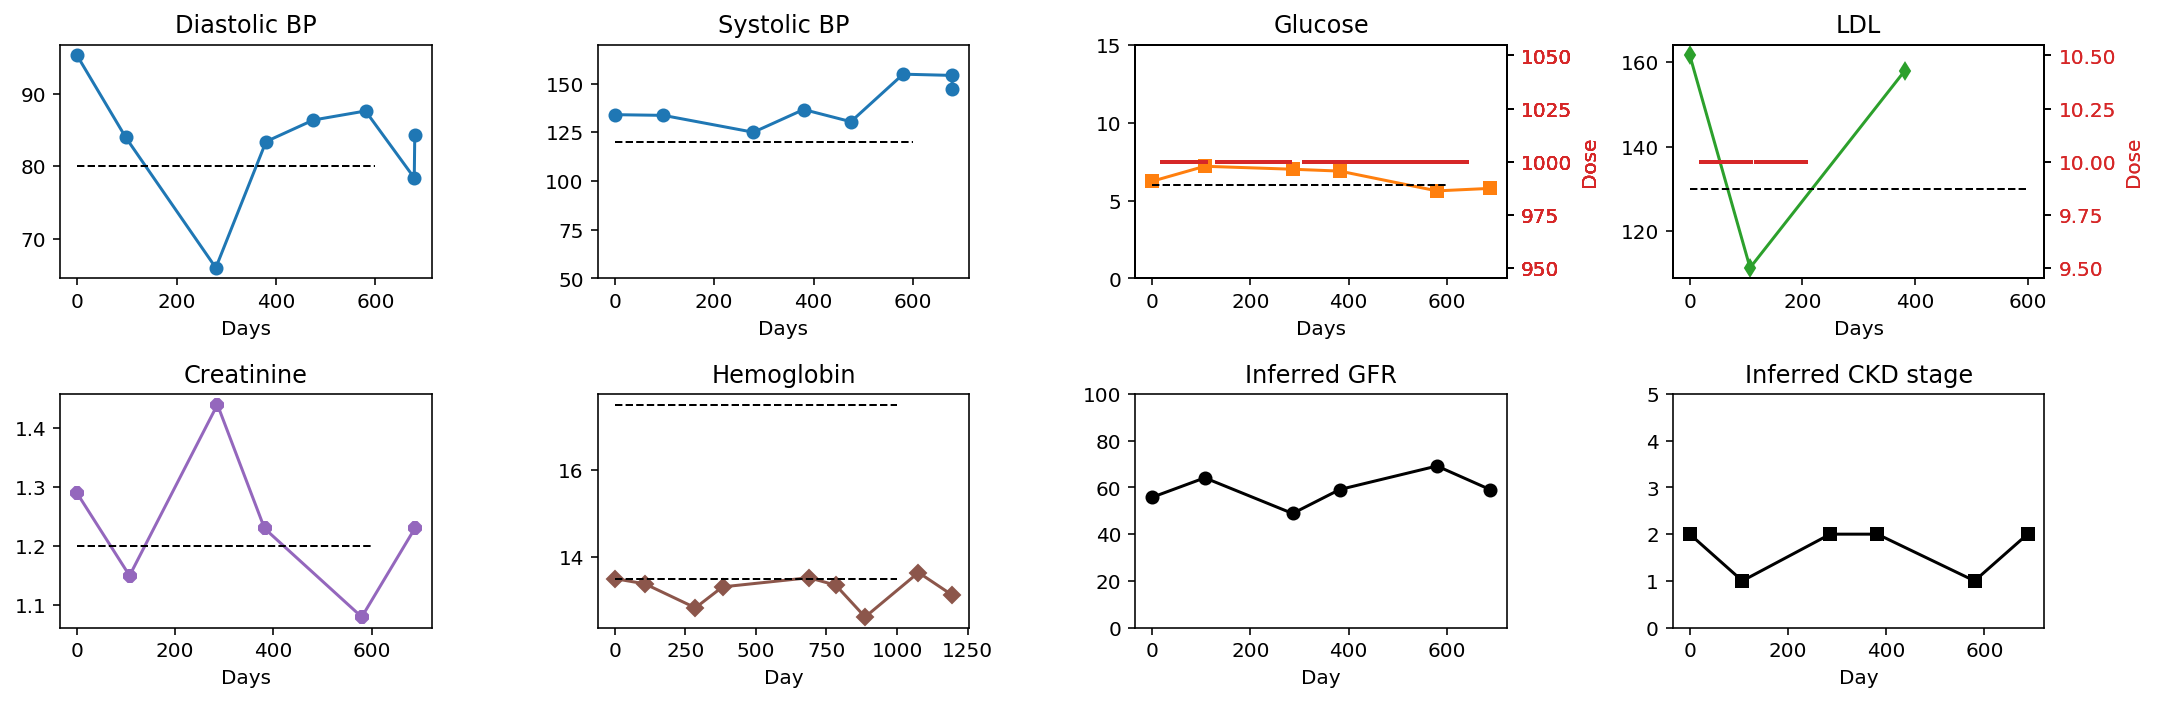

In [17]:
patient_profile(0)

Patient 0 has high blood pressure, diabetes, high cholesterol, elevated creatinine and low hemoglobin, meaning that he is unhealthy in every metric. In fact, the patient doesn't respond to atorvastatin, as his LDL has increased even after taking it. Thus, with all blood metrics unhealthy and lack of response to treatment, CKD advances.

Patient ID 226 [['Black' 'Female' 76]]
CKD progressed  [False]
All drugs  ['atorvastatin' 'carvedilol' 'metformin']


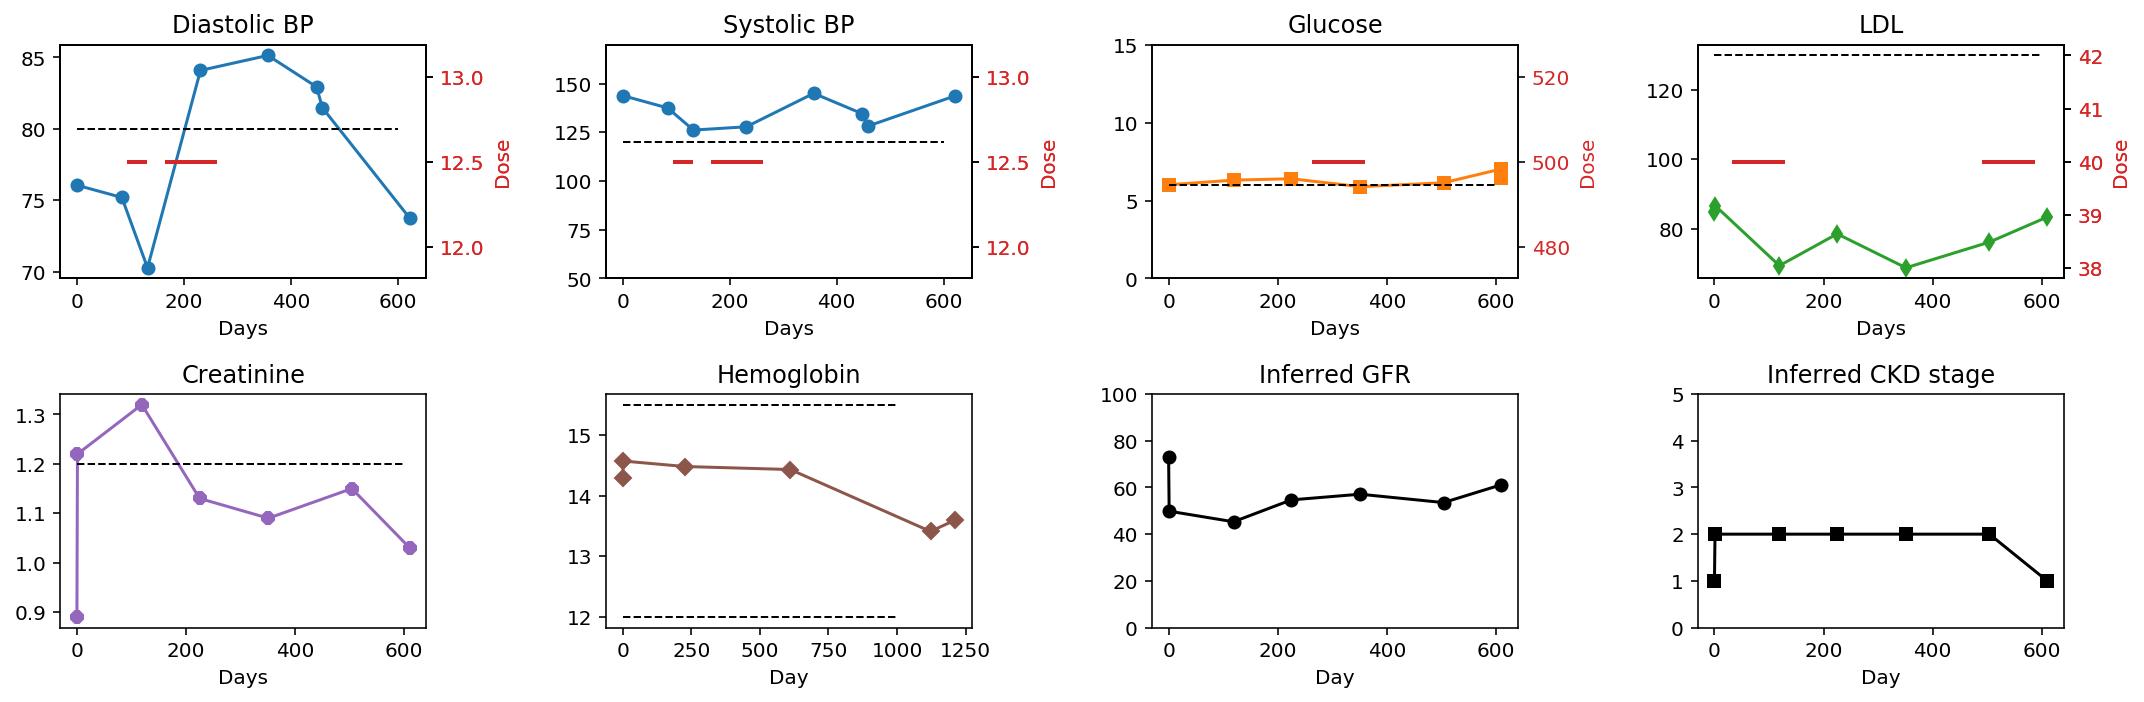

In [18]:
patient_profile(226)

Patient 226 has high blood pressure and diabetes but takes medication to treat high BP, diabetes and cholesterol. Notably, after taking the blood pressure medication, the diastolic blood pressure peaks and ultimately drops to a healthy level by the end of the observation period. In the end Patient 226's CKD does not progress.

Note however that these are just two relatively 'neatly behaving' cases, there are exceptions where the condition appears to be improving and yet the CKD stage advances.

### Feature engineering

**Design considerations.** 

**Avoid too many features**. A paper by Hua *et al* [1] suggests that for a dataset of $N$ samples, the optimal number of features is $N_f \sim N$ if they are guaranteed to be uncorrelated to each other, but $N_f \sim \sqrt{N}$ if they are highly correlated to each other. From data exploration I find that the data here falls into neither category. Accounting for the data imbalance and splitting for training data I'll have in the order of $N \sim 100$  patients only, so by that heuristic guideline an acceptable number of features is $N_f \sim 10$. Note that the number of features can scale exorbitantly because there are 6 blood test values (two BPs, glucose, LDL, creatinine, Hgb), 3-5 underlying diseases, medicines and others. 

**The model must incorporate temporal dynamics**. The model needs a way to capture how each patient is doing in time i.e. whether his or her condition gets better or worse.

[1] 10.1093/bioinformatics/bti171.


#### Features based on blood indicators

These features basically tell us, based on blood levels, what diseases the patient suffers from.

**Severity of each blood indicator at the end of treatment (6 features).** We want to know, when the patient is above or below the healthy baseline, exactly how much is the patient overshooting the baseline. Here we are focusing on the very last measurements of each indicator. 

**Severity of each blood indicator at the beginning of treatment (6 features).** Same, but at the beginning.

**GFR value at the beginning of treatment (1 feature).** Calculates kidney function from creatinine, age, gender and race at the beginning of treatment (i.e. from the first value of creatinine). I will drop age, gender and race from the feature matrix.

**GFR value at the end of treatment (1 feature).** Same, but at the end of treatment (defined as the last recorded value of creatinine). 

**What the last crossing is (6 features).** We expect that of all the crossings, it is probably the very last one that matters most. Note that in quite a few cases the last crossing is very close to the beginning, but the study is typically over $\sim 1000$ days or 3 years. Therefore we will do the following: if the last crossing is from healthy to unhealthy within 6 months of the end of treatment, assign -1; if the last crossing is from unhealthy to healthy within 6 months of the end of treatment, assign +1; else, assign 0. 


#### Medication and diseases

These features tell us what the patient is doing about their underlying diseases and how active they are with medical treatment. There is a gap in the data in that (from manual inspection) I realised that the only medications that are covered in the data set are for blood pressure, cholesterol and diabetes only. 

**What medications a patient is taking.** This is to take care of the possibility that there is a particular medication that is unusually good at treating CKD. 

**What categories of disease a patient is currently taking medication for (3 features).** For example, the patient is considered to be treating cholesterol if he or she is taking a statin.

**Duration of medication (1 feature).** During the observation period, what is the fraction of time that the patient is on medication. 

**Gap to first prescription (1 feature).** What is the number of days that a patient waits before receiving first prescription.

### Feature engineering: Crossings

In [19]:
def crossovers(metric, n, gender='Male'):
    '''
    (a) Counts the number of crossovers from healthy to unhealthy thresholds.
    (b) Determines whether the last crossover is good (unhealthy to healthy +1), bad (healthy to unhealthy -1), 
        or neither (0).
    
            metric: blood test type
            n: patient ID
            gender: whether patient is male or female
            
    '''
    if gender=='Male':
        hgb_val = 13.5
    else:
        hgb_val = 12
        
    blood_val = {'dbp': 80, 'glucose': 6, 'creatinine': 1.2, 'hgb':hgb_val, 'sbp': 120, 'ldl':130 }
    
    # The healthy threshold for the given metric
    condition = pp[metric][:,0] - blood_val[metric]
    
    if metric is not 'hgb': 
        # NB: In all tests except Hgb, the unhealthy value is reached above the threshold.
        crossover_good2bad = [((condition[i] > 0) & (condition[i+1] < 0)) for i in range(len(condition)-1)]
        crossover_bad2good = [((condition[i] < 0) & (condition[i+1] > 0)) for i in range(len(condition)-1)]
    else:
        crossover_bad2good = [((condition[i] > 0) & (condition[i+1] < 0)) for i in range(len(condition)-1)]
        crossover_good2bad = [((condition[i] < 0) & (condition[i+1] > 0)) for i in range(len(condition)-1)]
        
    
    num_crossovers = sum(crossover_good2bad) + sum(crossover_bad2good)
    
    if num_crossovers == 0:
        last_crossover = 0
    else:
        #crossover = [((condition[i] > 0) & (condition[i+1] < 0)) or ((condition[i] < 0) & (condition[i+1] > 0)) for i in range(len(condition)-1)] 
        #find_co = argwhere(array(crossover) == True)[0][0]        
        #if [find_co] in argwhere(array(crossover_bad2good)==True):
        #    last_crossover = -1
        #elif [find_co] in argwhere(array(crossover_good2bad)==True):
        #    last_crossover = +1
        crossover = [((condition[i] > 0) & (condition[i+1] < 0)) or ((condition[i] < 0) & (condition[i+1] > 0)) for i in range(len(condition)-1)] 
        find_co = argwhere(array(crossover) == True)[0][0]        
        if [find_co] in argwhere(array(crossover_bad2good)==True):
            if pp[metric][:,1][-1] - pp[metric][:,1][find_co] < 6*30:
                last_crossover = -1
            else:
                last_crossover = 0
        elif [find_co] in argwhere(array(crossover_good2bad)==True):
            if pp[metric][:,1][-1] - pp[metric][:,1][find_co] < 6*30:
                last_crossover = 1
            else:
                last_crossover = 0
            
            
    return num_crossovers, last_crossover

In [20]:
#### Generate crossover count and last crossover features.

blood_tests = ['glucose', 'sbp', 'dbp', 'creatinine', 'hgb', 'ldl']
x_glu = []; x_sbp = []; x_dbp = []; x_creatinine = []; x_hgb=[]; x_ldl = [];
xl_glu = []; xl_sbp = []; xl_dbp = []; xl_creatinine = []; xl_hgb=[]; xl_ldl = [];
xla_glu = []; xla_sbp = []; xla_dbp = []; xla_creatinine = []; xla_hgb=[]; xla_ldl = [];

count_array = [x_glu, x_sbp, x_dbp, x_creatinine, x_hgb, x_ldl]
last_array = [xl_glu, xl_sbp, xl_dbp, xl_creatinine, xl_hgb, xl_ldl]
last_alt_array = [xla_glu, xla_sbp, xla_dbp, xla_creatinine, xla_hgb, xla_ldl]

for i in range(300):
    pp = retrieve_patient(i)
    gender = pp['demo'][0][1]
    
    for bt, ca, la in zip(blood_tests, count_array, last_array):
        num_x, last_x = crossovers(bt, i, gender)
        ca.append(num_x)
        la.append(last_x)


### Feature engineering: disease severity at the end of treatment

A note about implementation: I will keep the sign consistent, such that the value returned is positive when the disease is more severe. 

In [21]:
# Severity of disease at the end of treatment
sev_glu = []; sev_sbp = []; sev_dbp = []; sev_creatinine = []; sev_hgb=[]; sev_ldl = [];
sev_end = [sev_glu, sev_sbp, sev_dbp, sev_creatinine, sev_hgb, sev_ldl]

# Severity of disease at the begining of treatment
sev_glu_b = []; sev_sbp_b = []; sev_dbp_b = []; sev_creatinine_b = []; sev_hgb_b=[]; sev_ldl_b = [];
sev_beg = [sev_glu_b, sev_sbp_b, sev_dbp_b, sev_creatinine_b, sev_hgb_b, sev_ldl_b]

blood_tests = ['glucose', 'sbp', 'dbp', 'creatinine', 'hgb', 'ldl']

for i in range(300):
    pp = retrieve_patient(i)
    gender = pp['demo'][0][1]
    if gender=='Male':
        hgb_val = 13.5
    else:
        hgb_val = 12
    blood_val = {'dbp': 80, 'glucose': 6, 'creatinine': 1.2, 'hgb':hgb_val, 'sbp': 120, 'ldl':130 }
    
    for bt,sev, seb in zip(blood_tests, sev_end, sev_beg):
        condition = pp[bt][:,0][-1] - blood_val[bt]  
        condition_beg = pp[bt][:,0][0] - blood_val[bt]      
        
        if bt is not 'hgb':
            sev.append(condition)
            seb.append(condition_beg)
            
        else:
            sev.append(-condition)
            seb.append(-condition_beg)
            

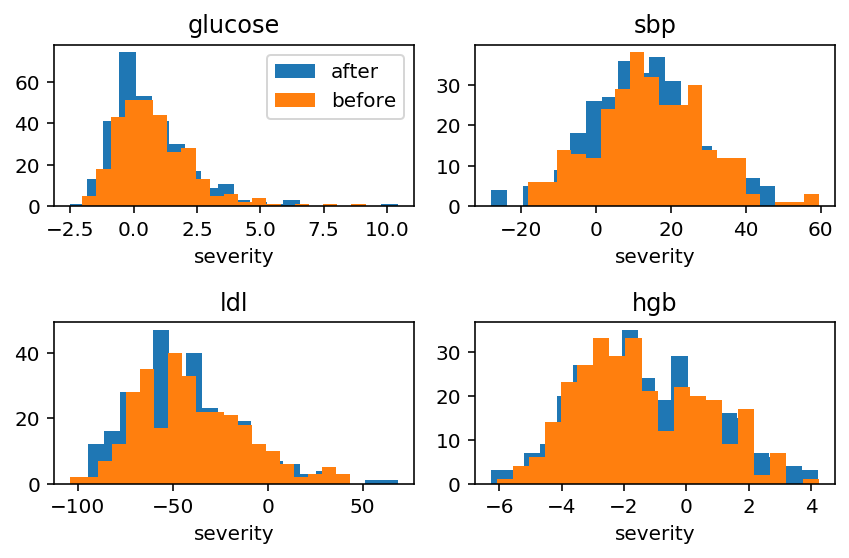

In [22]:
plt.subplot(221)
plt.hist(sev_glu, bins=20, label='after')
plt.hist(sev_glu_b, bins=20, label='before')
plt.legend(loc='best')
plt.xlabel('severity')

plt.title('glucose')
plt.subplot(222)
plt.hist(sev_sbp, bins=20)
plt.hist(sev_sbp_b, bins=20)
plt.xlabel('severity')

plt.title('sbp')
plt.subplot(223)
plt.hist(sev_ldl, bins=20)
plt.hist(sev_ldl_b, bins=20)
plt.xlabel('severity')

plt.title('ldl')
plt.subplot(224)
plt.hist(sev_hgb, bins=20)
plt.hist(sev_hgb_b, bins=20)
plt.xlabel('severity')

plt.title('hgb')
plt.tight_layout()

### Feature engineering: inferred GFR 

In [23]:
gfr_before = []
gfr_after = []
for i in range(300):
    pp = retrieve_patient(i, calcGFR=True)
    gfr_before.append(pp['gfr'][0])
    gfr_after.append(pp['gfr'][-1])    

### Feature engineering: gap to first medication

In [24]:
gap_list = []
blood_tests = ['glucose', 'sbp', 'dbp', 'creatinine', 'hgb', 'ldl']

for i in range(300):
    pp = retrieve_patient(i)
    try:
        gap_list.append( min(pp['meds'][:,2]) )
    except:
        max_lists = []
        for bt in blood_tests:
            max_lists.append( max(pp[bt][:,1]))
        
        gap_list.append( max(max_lists) )
        

### Feature engineering: fraction of days on medication

In [25]:
'''
Calculates the maximum number of days observed.
'''
max_day_full = []
vitals = ['creatinine', 'glucose', 'hgb', 'ldl', 'dbp', 'sbp']
for i in range(300):
    pp = retrieve_patient(i)
    max_day_list = []
    for v in vitals:
        max_day_list.append(max(pp[v][:,-1]))
    max_day = max(max_day_list)
    max_day_full.append(max_day)
    
frac_treat_list = []
for i, mdf in enumerate(max_day_full):
    pp = retrieve_patient(i)
    day_list = zeros(len(max_day_full))
    for pm in pp['meds']:
        day_list[pm[2]:pm[3]] = 1
    frac_treat_list.append( mean(day_list) )    

### Feature engineering: number of treatments

In [26]:
def treatment_list(n):
    pid = n
    pp = retrieve_patient(pid, calcGFR=False)

    bp_list = ['valsartan', 'metoprolol', 'bisoprolol', 'atenolol', 'carvedilol',
               'olmesartan', 'irbesartan', 'telmisartan', 'labetalol', 'nebivolol', 'propranolol']
    diab_list = ['metformin', 'canagliflozin', 'dapagliflozin']
    statin_list = ['atorvastatin', 'rosuvastatin', 'pravastatin','simvastatin', 'lovastatin', 'pitavastatin']

    med_list = unique(pp['meds'][:,0])
    treat_diab = 0
    treat_hbp = 0
    treat_chol = 0
    
    for ml in med_list:
        if ml in bp_list:
            treat_hbp = 1
        if ml in diab_list:
            treat_diab = 1
        if ml in statin_list:
            treat_chol = 1
    
    #print(treat_hbp, treat_diab, treat_chol)
    return treat_diab, treat_hbp, treat_chol

In [27]:
treat_diab = []; treat_hbp = []; treat_chol = [];
for i in range(300):
    td, th, tc = treatment_list(i)
    treat_diab.append(td); treat_hbp.append(th); treat_chol.append(tc);

### Feature engineering: what medication each person is on

In [28]:
all_meds = meds['drug'].unique()
all_med_array = zeros(len(all_meds))

for i in range(300):
    med_store = []
    pp = retrieve_patient(i)
    try:
        for patient_med in unique(pp['meds'][:,0]):
            med_store.append((all_meds == patient_med).astype(int))
        med_store = array(sum(med_store, axis=0))
        all_med_array = vstack([all_med_array, med_store])
    except:
        all_med_array = vstack([all_med_array, zeros(len(all_meds))])


all_med_array = all_med_array[1:,:]

In [29]:
all_med_df = pd.DataFrame(all_med_array, columns=all_meds)

### Feature engineering: the dose amount that each person is on

In [30]:
all_meds = meds['drug'].unique()
all_meddose_array = zeros(len(all_meds))

for i in range(300):
    med_store = []
    pp = retrieve_patient(i)
    try:
        for patient_med in unique(pp['meds'][:,0]):
            total_dose = mean(pp['meds'][:,1][pp['meds'][:,0] == patient_med])
            #sum(pp['meds'][:,1][pp['meds'][:,0] == patient_med] * (pp['meds'][:,3][pp['meds'][:,0] == patient_med] - pp['meds'][:,2][pp['meds'][:,0] == patient_med]))
            med_store.append((all_meds == patient_med).astype(int)*total_dose)
        med_store = array(sum(med_store, axis=0))
        all_meddose_array = vstack([all_meddose_array, med_store])
    except:
        all_meddose_array = vstack([all_meddose_array, zeros(len(all_meds))])


all_meddose_array = all_meddose_array[1:,:]
all_meddose_df = pd.DataFrame(all_meddose_array, columns=all_meds)

### Feature engineering: number of medications

In [31]:
num_meds = []
for i in range(300):
    pp = retrieve_patient(i)
    num_meds.append( len(unique(pp['meds'][:,0])))

### Predictions

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.naive_bayes import GaussianNB

Here I am going to assemble the model together, pre-process the data, and then carry out some preliminary analysis. 

Some considerations in building the model

**Data imbalance.** I know from earlier that the dataset is unbalanced. To avoid this problem I use a package called `imbalanced-learn` to undersample the prediction class that is over-represented. The specific function is `RandomUnderSampler()`. 

**Scaling.** I use a standard scaler `sklearn.preprocessing.StandardScaler()` to standardize the input variables (subtract the mean and divide by standard deviation of a feature column). There are other possible options but I find this one to be reasonable because the data is clean enough that there are no outliers. 

**Data split.** I split the data into training and test sets, with a test size 30%. I don't have a specific reason to choose that number. 

In [33]:
def run_single(X,y, cl='LogisticRegression'):
    '''
    Runs a single iteration of a classifier and returns the accuracy
    '''
    rus = RandomUnderSampler()
    X_rs, y_rs = rus.fit_resample(X,y)

    # Run a standard scaler.
    scaler = StandardScaler()
    X_rs = scaler.fit_transform(X_rs)
    
    X_train, X_test, y_train, y_test = train_test_split(X_rs,y_rs, test_size=0.3) 

    
    classifiers = {'DecisionTree': DecisionTreeClassifier(),
                   'AdaBoost': AdaBoostClassifier(),
                   'GradientBoosting': GradientBoostingClassifier(),
                   'SVC': SVC(probability=True),
                   'RandomForest': RandomForestClassifier(),
                   'GaussianNB': GaussianNB(),
                   'KNeighbors': KNeighborsClassifier(3),
                   'LogisticRegression': LogisticRegression(),
                   'LinearDiscAnalysis': LinearDiscriminantAnalysis(n_components=1),                   
                  }
    model = classifiers[cl]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds), roc_auc_score(y_test, preds)


In [34]:
def run_models(X,y):
    '''
    Runs a bunch of models and returns a classification report for a particular choice of X, y.
    This function takes care of data imbalance by randomly undersampling the major outcome.
    '''
    rus = RandomUnderSampler()
    X_rs, y_rs = rus.fit_resample(X,y)

    # Run a standard scaler.
    scaler = StandardScaler()
    X_rs = scaler.fit_transform(X_rs)
    
    X_train, X_test, y_train, y_test = train_test_split(X_rs,y_rs, test_size=0.3) 

    
    classifiers = {'Decision tree': DecisionTreeClassifier(),
                   'AdaBoost': AdaBoostClassifier(),
                   'Gradient boost': GradientBoostingClassifier(),
                   'Sup. vec. mac.': SVC(probability=True),
                   'Random forest': RandomForestClassifier(),
                   'Gaussian NB': GaussianNB(),
                   'K neighbours': KNeighborsClassifier(3),
                   'LinDiscAna.': LinearDiscriminantAnalysis(n_components=1),                   
                   'Logistic regr.': LogisticRegression(),
                  }
    for cl in classifiers:
        model = classifiers[cl]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print(cl, '\t acc', round(accuracy_score(y_test, preds),3) , '\t roc_auc', round(roc_auc_score(y_test, preds),3) )

    print(classification_report(y_test, preds))

In [35]:
def run_logreg(X,y):
    '''
    Runs logistic regression a number of times under different undersampling and splits.
    '''
    classifiers = {
                   #'Random forest': RandomForestClassifier(),        
                   'Logistic regr.': LogisticRegression(),
                  }
    
    acc_list = []
    
    for i in range(600):
        rus = RandomUnderSampler()
        X_rs, y_rs = rus.fit_resample(X,y)
        X_train, X_test, y_train, y_test = train_test_split(X_rs,y_rs, test_size=0.3) 
        
        for cl in classifiers:
            model = classifiers[cl]
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc_list.append(accuracy_score(y_test, preds))

    print(mean(acc_list))

In [36]:
features = pd.concat([

    # Disease severity at the end of treatment
    pd.DataFrame(sev_glu, columns=['sev_glu']),
    pd.DataFrame(sev_sbp, columns=['sev_sbp']),
    pd.DataFrame(sev_dbp, columns=['sev_dbp']),
    pd.DataFrame(sev_creatinine, columns=['sev_creat']),
    pd.DataFrame(sev_hgb, columns=['sev_hgb']),
    pd.DataFrame(sev_ldl, columns=['sev_ldl']),        
    # Variable to predict
    stage['Stage_Progress'].astype(int)
], axis=1)

X = features[features.columns[0:-1]]
y = features[features.columns[-1]]
#run_logreg(X,y)
run_models(X,y)

Decision tree 	 acc 0.583 	 roc_auc 0.583
AdaBoost 	 acc 0.55 	 roc_auc 0.55
Gradient boost 	 acc 0.683 	 roc_auc 0.683
Sup. vec. mac. 	 acc 0.683 	 roc_auc 0.683
Random forest 	 acc 0.633 	 roc_auc 0.633
Gaussian NB 	 acc 0.65 	 roc_auc 0.65
K neighbours 	 acc 0.633 	 roc_auc 0.633
LinDiscAna. 	 acc 0.717 	 roc_auc 0.717
Logistic regr. 	 acc 0.7 	 roc_auc 0.7
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        30
           1       0.69      0.73      0.71        30

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60



The results are quite encouraging. With only the disease severity before treatment, we get about 60-65% accuracy, and with the severity after treatment, this goes up to 70-80%. However, the accuracy fluctuates quite a bit and it's hard to have a sense of what its true value is. 

Since I know that logistic regression performs best nearly all the time, I evaluate test performance by running logistic regression 600 times, each time with a different undersampling and with a different split of the training/test sets. The accuracy converges to a fairly consistent value (within $\pm 0.5\%$). 

In [37]:
features = pd.concat([

    # Disease severity at the end of treatment
    pd.DataFrame(sev_glu, columns=['sev_glu']),
    pd.DataFrame(sev_sbp, columns=['sev_sbp']),
    pd.DataFrame(sev_dbp, columns=['sev_dbp']),
    pd.DataFrame(sev_creatinine, columns=['sev_creat']),
    pd.DataFrame(sev_hgb, columns=['sev_hgb']),
    pd.DataFrame(sev_ldl, columns=['sev_ldl']),

    # Disease severity at the beginning of treatment
    pd.DataFrame(sev_glu_b, columns=['sev_glu_b']),
    pd.DataFrame(sev_sbp_b, columns=['sev_sbp_b']),
    pd.DataFrame(sev_dbp_b, columns=['sev_dbp_b']),
    pd.DataFrame(sev_creatinine_b, columns=['sev_creat_b']),
    pd.DataFrame(sev_hgb_b, columns=['sev_hgb_b']),
    pd.DataFrame(sev_ldl_b, columns=['sev_ldl_b']),
            
    # Variable to predict
    stage['Stage_Progress'].astype(int)
], axis=1)

X = features[features.columns[0:-1]]
y = features[features.columns[-1]]
run_logreg(X,y)

0.7816388888888888


Modelling the disease severity before and after treatment *alone* is enough to achieve about 77.5% accuracy (again, this fluctuates a little bit typically by $\pm 0.5\%$).

In [38]:
features = pd.concat([

    # Disease severity at the end of treatment
    pd.DataFrame(sev_glu, columns=['sev_glu']),
    pd.DataFrame(sev_sbp, columns=['sev_sbp']),
    pd.DataFrame(sev_dbp, columns=['sev_dbp']),
    pd.DataFrame(sev_creatinine, columns=['sev_creat']),
    pd.DataFrame(sev_hgb, columns=['sev_hgb']),
    pd.DataFrame(sev_ldl, columns=['sev_ldl']),

    # Disease severity at the beginning of treatment
    pd.DataFrame(sev_glu_b, columns=['sev_glu_b']),
    pd.DataFrame(sev_sbp_b, columns=['sev_sbp_b']),
    pd.DataFrame(sev_dbp_b, columns=['sev_dbp_b']),
    pd.DataFrame(sev_creatinine_b, columns=['sev_creat_b']),
    pd.DataFrame(sev_hgb_b, columns=['sev_hgb_b']),
    pd.DataFrame(sev_ldl_b, columns=['sev_ldl_b']),
    
    # Last crossing from good-to-unhealthy or unhealthy-to-good within the last 6 months.
    pd.DataFrame(xl_glu, columns=['xl_glu']),
    pd.DataFrame(xl_sbp, columns=['xl_sbp']),
    pd.DataFrame(xl_dbp, columns=['xl_dbp']),
    pd.DataFrame(xl_creatinine, columns=['xl_creatinine']),
    pd.DataFrame(xl_hgb, columns=['xl_hgb']),
    pd.DataFrame(xl_ldl, columns=['xl_ldl']),
    
    # Variable to predict
    stage['Stage_Progress'].astype(int)
], axis=1)

X = features[features.columns[0:-1]]
y = features[features.columns[-1]]
run_logreg(X,y)

0.7777777777777777


Despite the effort, the last crossing feature did not substantially improve accuracy.

### Which features are important?

Now I am going to take a slightly different tack to what I have done before. I will add all the features I've engineered and perform the Shapley Additive Explanations (SHAP) analysis to figure out which of the features are important and which aren't. Then I'll prune those that are statistically significant into a model that has the best accuracy for the least features. Once I have assembled that optimal model I proceed with hyperparameter optimization. 

Had I found that random forests were performing best from my initial analysis I would have proceeded by using the more established feature importance analysis for random forests. 

In [39]:
features = pd.concat([

    # Disease severity at the end of treatment
    pd.DataFrame(sev_glu, columns=['Glucose (after)']),
    pd.DataFrame(sev_sbp, columns=['Sys. BP (after)']),
    pd.DataFrame(sev_dbp, columns=['Dia. BP (after)']),
    pd.DataFrame(sev_creatinine, columns=['Creatinine (after)']),
    pd.DataFrame(sev_hgb, columns=['Hemoglobin (after)']),
    pd.DataFrame(sev_ldl, columns=['LDL (after)']),

    # Disease severity at the beginning of treatment
    pd.DataFrame(sev_glu_b, columns=['Glucose (before)']),
    pd.DataFrame(sev_sbp_b, columns=['Sys. BP (before)']),
    pd.DataFrame(sev_dbp_b, columns=['Dia. BP (before)']),
    pd.DataFrame(sev_creatinine_b, columns=['Creatinine (before)']),
    pd.DataFrame(sev_hgb_b, columns=['Hemoglobin (before)']),
    pd.DataFrame(sev_ldl_b, columns=['LDL (before)']),
    
    # GFR values before and after treatment (incorporates creatinine, age, gender, race)
    pd.DataFrame(gfr_before, columns=['Glom. filt. rate (before)']),
    pd.DataFrame(gfr_after, columns=['Glom. filt. rate (after)']),
    
    # Last crossing from good-to-unhealthy or unhealthy-to-good within the last 6 months of treatment
    pd.DataFrame(xl_glu, columns=['xl_glu']),
    pd.DataFrame(xl_sbp, columns=['xl_sbp']),
    pd.DataFrame(xl_dbp, columns=['xl_dbp']),
    pd.DataFrame(xl_creatinine, columns=['xl_creatinine']),
    pd.DataFrame(xl_hgb, columns=['xl_hgb']),
    pd.DataFrame(xl_ldl, columns=['xl_ldl']),    

    # Medication features: number of medications, what diseases patients are treating for
    all_med_df,

    pd.DataFrame(num_meds, columns=['Number of medications']),    
    pd.DataFrame(gap_list, columns=['Gap to first prescription']),    
    
    # Variable to predict
    stage['Stage_Progress'].astype(int)
], axis=1)

X = features[features.columns[0:-1]]
y = features[features.columns[-1]]

In [40]:
model = LogisticRegression()
rus = RandomUnderSampler()
X_rs, y_rs = rus.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_rs,y_rs, test_size=0.3) 
model.fit(X_train, y_train)

explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)

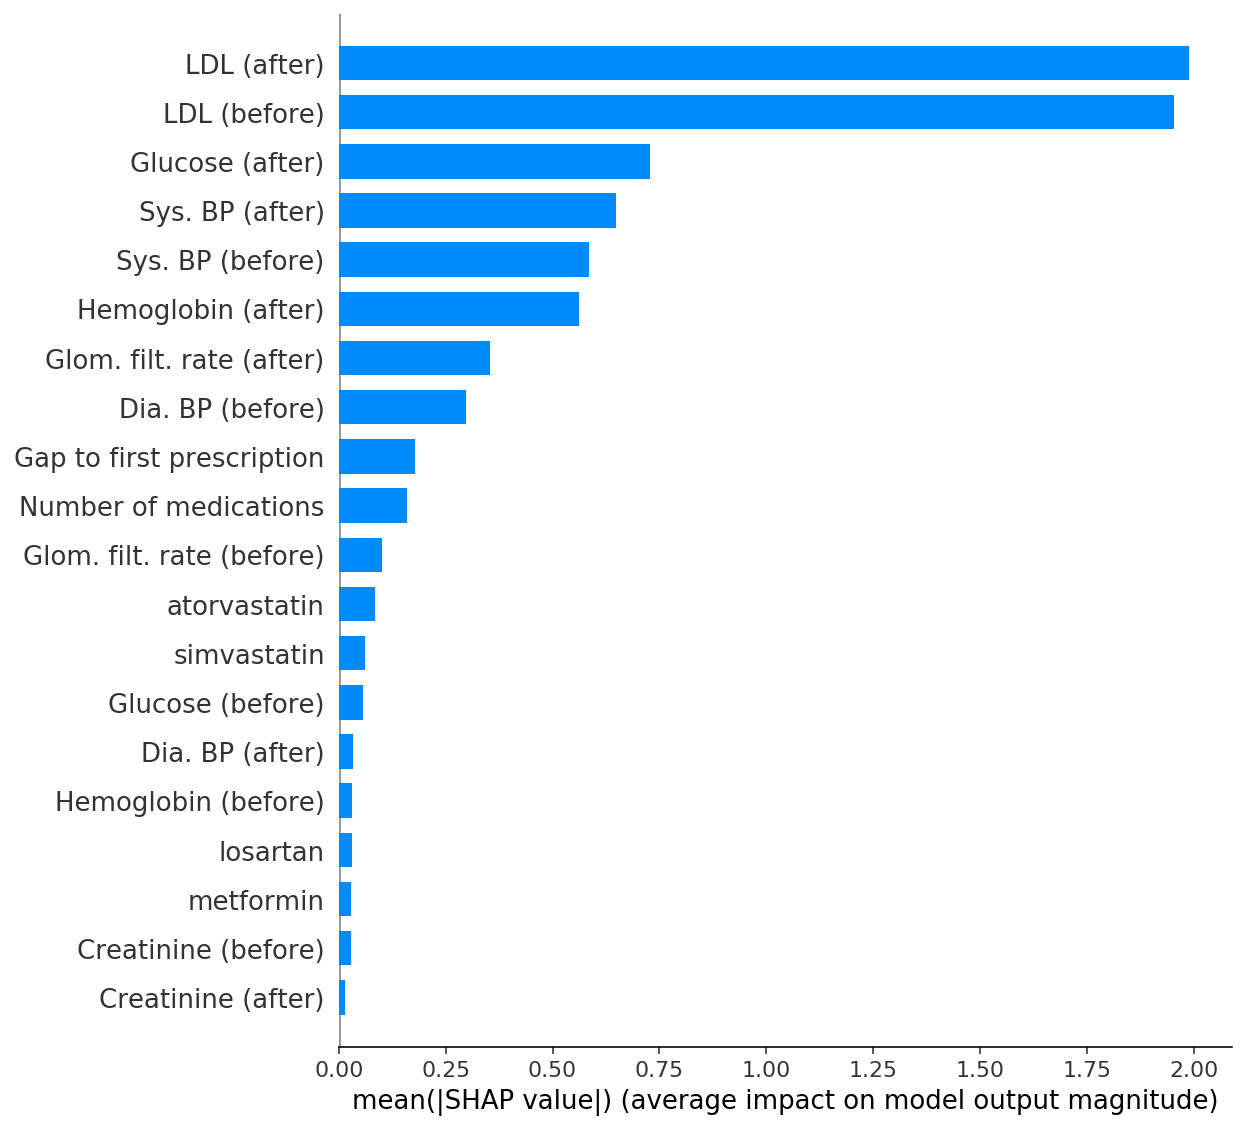

In [41]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns.values, plot_type='bar')

Interestingly, the medication features don't seem to affect the model much; they rank very low in SHAP value. 

In [42]:
shp = pd.DataFrame(shap_values, columns=X.columns.values)
shp_abs = abs(shp)
ranked_features = shp_abs.mean().sort_values(ascending=False)

In [43]:
shp_abs.mean().sort_values(ascending=False).head(10)

LDL (after)                  1.989115
LDL (before)                 1.954486
Glucose (after)              0.727021
Sys. BP (after)              0.648390
Sys. BP (before)             0.586385
Hemoglobin (after)           0.561744
Glom. filt. rate (after)     0.354755
Dia. BP (before)             0.298583
Gap to first prescription    0.179009
Number of medications        0.160638
dtype: float64

### Assembling the final model

I will only take the top $N$ features from the SHAP model and train those columns only.

In [44]:
features_final = features[ranked_features[0:8].index.values]
X = features_final
y = features[features.columns[-1]]
run_models(X,y)

Decision tree 	 acc 0.567 	 roc_auc 0.57
AdaBoost 	 acc 0.733 	 roc_auc 0.735
Gradient boost 	 acc 0.65 	 roc_auc 0.65
Sup. vec. mac. 	 acc 0.717 	 roc_auc 0.718
Random forest 	 acc 0.633 	 roc_auc 0.634
Gaussian NB 	 acc 0.7 	 roc_auc 0.703
K neighbours 	 acc 0.7 	 roc_auc 0.705
LinDiscAna. 	 acc 0.767 	 roc_auc 0.768
Logistic regr. 	 acc 0.767 	 roc_auc 0.768
              precision    recall  f1-score   support

           0       0.74      0.79      0.77        29
           1       0.79      0.74      0.77        31

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



### Learning curve: how many features are required to predict the data

Here I will check how well some selected classifiers perform in terms of accuracy, as a function of number of features identified by SHAP (in other words, we train on the top 1 SHAP features, top 2 SHAP features, and so on).  To obtain the accuracy I run each classifier 50 times. Because this can be quite time consuming for some of the classifiers, I won't try all of them.

Finished  LogisticRegression
Finished  GaussianNB
Finished  LinearDiscAnalysis
Finished  SVC


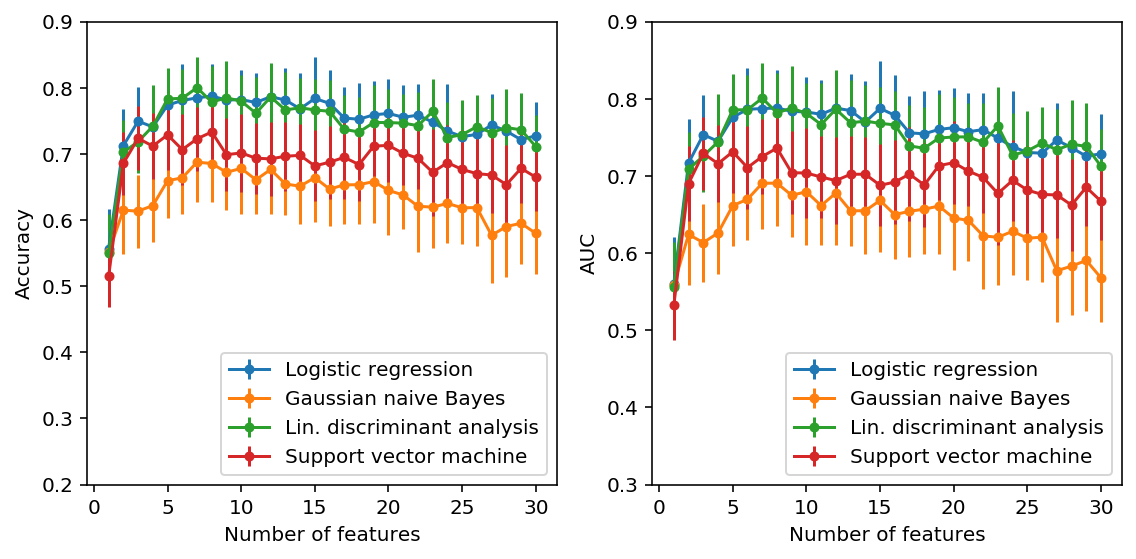

In [45]:
plt.figure(figsize=(8,4))
my_method = ['LogisticRegression', 'GaussianNB', 'LinearDiscAnalysis', 'SVC']
my_name = ['Logistic regression', 'Gaussian naive Bayes', 'Lin. discriminant analysis', 'Support vector machine']
for mm, nn in zip(my_method, my_name):
    acc_list = []
    acc_std_list =[]
    aucroc_list = []
    aucroc_std_list = []
    featnum_list = []
    for i in range(30):
        features_final = features[ranked_features[0:i+1].index.values]
        X = features_final
        y = features[features.columns[-1]]
        holder = []
        holder_auc = []
        for j in range(50):
            acc, aucroc = run_single(X,y, mm) # Note: each run_single will perform a unique undersample and unique train-test split.
            holder.append(acc)
            holder_auc.append(aucroc)
        acc_list.append(mean(holder))
        acc_std_list.append(std(holder))
        aucroc_list.append(mean(holder_auc))
        aucroc_std_list.append(std(holder_auc))
        featnum_list.append(i+1)
        
    plt.subplot(121)
    plt.errorbar(featnum_list, acc_list, yerr=acc_std_list, fmt='o', ls='-', ms=4, label=nn)
    plt.subplot(122)
    plt.errorbar(featnum_list, aucroc_list, yerr=aucroc_std_list, fmt='o', ls='-', ms=4, label=nn)
    
    print("Finished " , mm)
    
plt.subplot(121)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.ylim([0.2,0.9])

plt.legend(loc='lower right')
plt.subplot(122)
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.legend(loc='lower right')

plt.ylim([0.3,0.9])
plt.tight_layout()

Of the classifiers I was able to analyse in this way, `LogisticRegression` and `LinearDiscriminantAnalysis` performed the best, both reaching accuracies of 0.8 without hyperparameter tuning.

Another noteworthy finding is that only approximately the top 8-10 SHAP features are required to predict advancement of CKD staging at maximal accuracy. Beyond this one is faced with diminishing returns. Seeing this curve gives me some reasonable confidence that the SHAP analysis is working, since if SHAP was not correctly ranking feature importance we should see that the accuracy/AUC learning curves spike or behave in unexpected ways (such as returning suddenly to 0.5).

### Hyperparameter tuning

In [46]:
num_shap_features = 10

features_final = features[ranked_features[0:num_shap_features+1].index.values]
X = features_final
y = features[features.columns[-1]]
rus = RandomUnderSampler()
X_rs, y_rs = rus.fit_resample(X,y)

model = LogisticRegression()
param = {'C':logspace(-2,1,40), 'penalty' : ['l1', 'l2']}    
gsc = GridSearchCV(model, param, scoring='roc_auc',refit=True,cv=10, verbose=1)
gsc.fit(X_rs,y_rs)
print('Best roc_auc: {:.4}, with best: {}'.format(gsc.best_score_, gsc.best_params_))

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best roc_auc: 0.865, with best: {'C': 0.014251026703029978, 'penalty': 'l2'}


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    8.0s finished


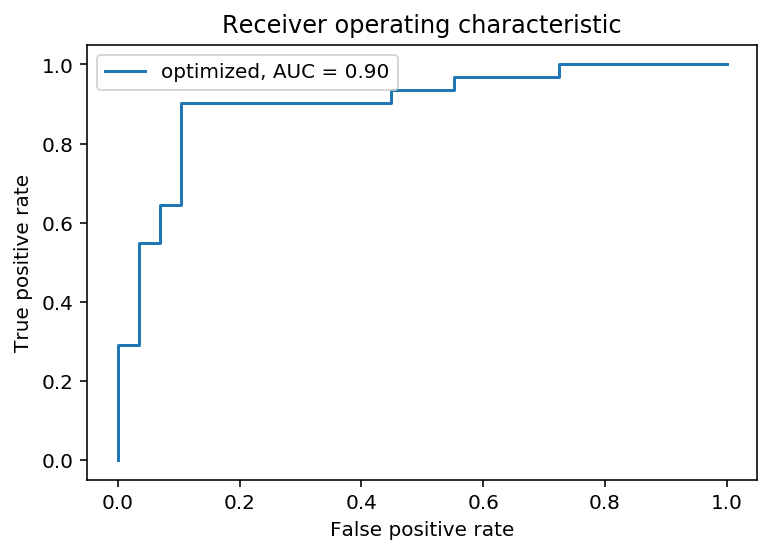

In [47]:
model = gsc.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(X_rs,y_rs, test_size=0.3) 
model.fit(X_train, y_train)
preds = model.predict(X_test)
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'C0', label = 'optimized, AUC = %0.2f' % roc_auc)

plt.title('Receiver operating characteristic')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')